In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import helmert

In [15]:
def makeComposition(n, D):
    """
    Create a random composition drawn from normal distribution. Composition will be of 
    D-dimension size, and there will be n compositions returned.
    """
    arr = [[np.random.rand() for x in range(D)] for row in range(n)]
    return np.array([[x/np.sum(row) for x in row] for row in arr])

def makeDirichletComposition(n, D):
    """
    Generate samples from a dirichlet distribution using an array of alpha distributions.
    """
    alphas = 2 ** np.random.randint(0,4, size=(n, D))
#     alphas = [[x for x in range(1, D+1)] for row in range(n)] 
    r = np.random.standard_gamma(alphas)
    return r / r.sum(-1, keepdims=True)

def clr(a):
    """
    Apply a centered log-ratio transformation to a ndarray.
    """
    arr = list(a)
    return np.array([np.array([np.log(x/(np.prod(row)**(1/len(row)))) for x in row]) for row in arr])

def clr_boxcox(a, p):
    """
    Apply a centered log-ratio transformation to a ndarray.
    """
    arr = list(a)
    return np.array([np.array([((x/(np.prod(row)**(1/len(row))))**p - 1) / p for x in row]) for row in arr])

def ilr(a):
    """
    The isometric logratio transformation function turns a given composition into an orthonormal
    basis in D-1 dimensions on the basis of a given variable (by default, the first column).
    """
    x = np.array(a)
    res = (((x.shape[1]-1) / (x.shape[1])) ** (1/2) * 
           np.log(x[:, 0].reshape((x.shape[0],1)) / 
                  (np.prod(x[:, 1:], axis=1).reshape((x.shape[0], 1))) ** 
                  (1/((x.shape[1]-1)))).reshape((x.shape[0],1)))

    i = 1
    while i < (x.shape[1] - 1):        
        res = np.concatenate((res, 
                              ((x.shape[1]-i-1) / (x.shape[1]-i)) ** (1/2) * 
                              np.log(x[:, i].reshape((x.shape[0],1)) / 
                                     (np.prod(x[:, i+1:], axis=1).reshape((x.shape[0], 1))) ** 
                                     (1/((x.shape[1]-i-1)))).reshape((x.shape[0],1))), axis=1)
        i+=1        
    return res

def ilr_boxcox(a, p):
    """
    The isometric logratio transformation function turns a given composition into an orthonormal
    basis in D-1 dimensions on the basis of a given variable (by default, the first column).
    """
    x = (np.e ** (p * np.log(a)) - 1) / p
    x = np.apply_along_axis(lambda val: (np.e ** (p * val) - 1) / p, axis=0, arr=x)
    x -= x.mean(axis=1).reshape(x.shape[0], 1)
    H = helmert(a.shape[1], full=False)
    H = H.transpose() / np.array([[2 for x in range(a.shape[1]-1)] for row in range(a.shape[1])])**(1/2)
    return np.matmul(x, H)


def plotCompositionPairs(data):
    """
    Make pair-wise plots of the features of an ndarray.
    """
    fig, axs = plt.subplots(data.shape[1], data.shape[1], figsize=(15,12))

    for i in range(data.shape[1]):
        for j in range(data.shape[1]):
            if i==j:
                continue
            ax = axs[i, j].hexbin(x=data[:, i], y=data[:, j], bins='log', gridsize=50, cmap='inferno')

    fig.colorbar(ax, ax=axs.ravel().tolist(), orientation='vertical', shrink=1/(data.shape[1]+.5))

In [16]:
n = 10000
D = 5
# data = makeComposition(n, D)
data = makeDirichletComposition(n, D)

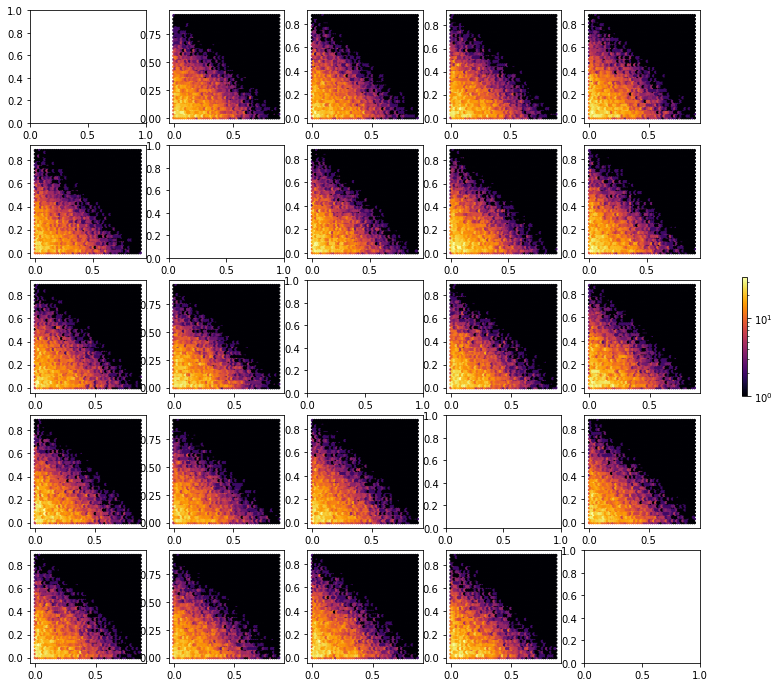

In [17]:
plotCompositionPairs(data)

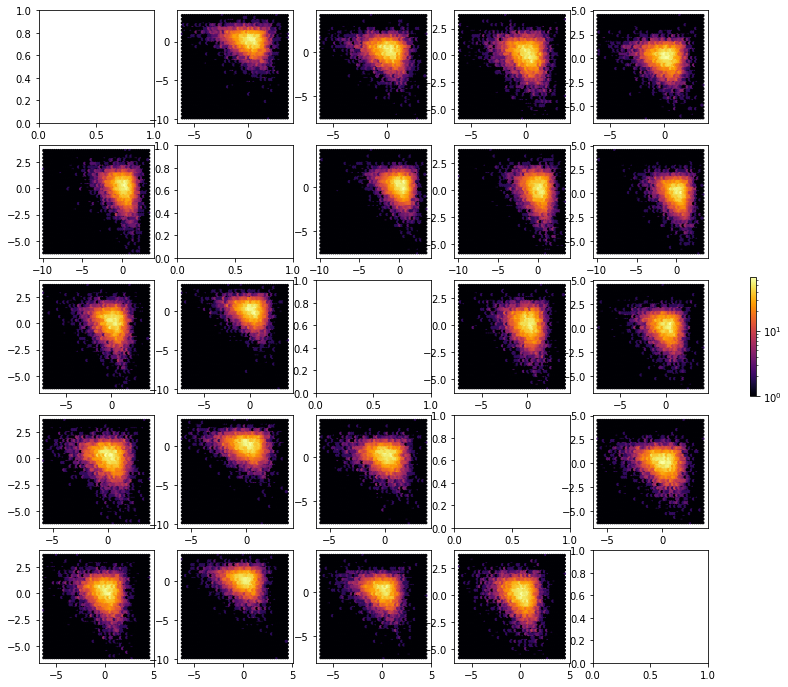

In [18]:
plotCompositionPairs(clr(data))

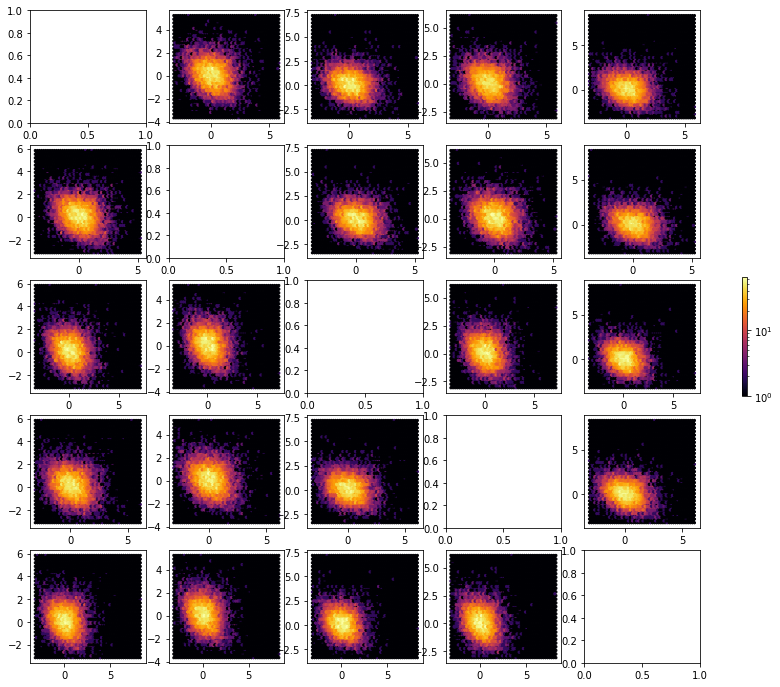

In [19]:
plotCompositionPairs(clr_boxcox(data, 0.25))

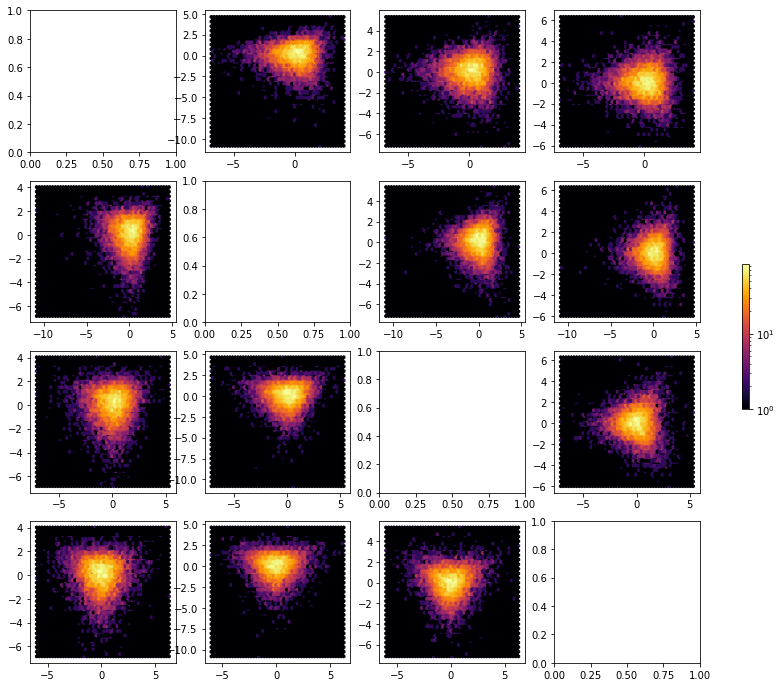

In [20]:
plotCompositionPairs(ilr(data))

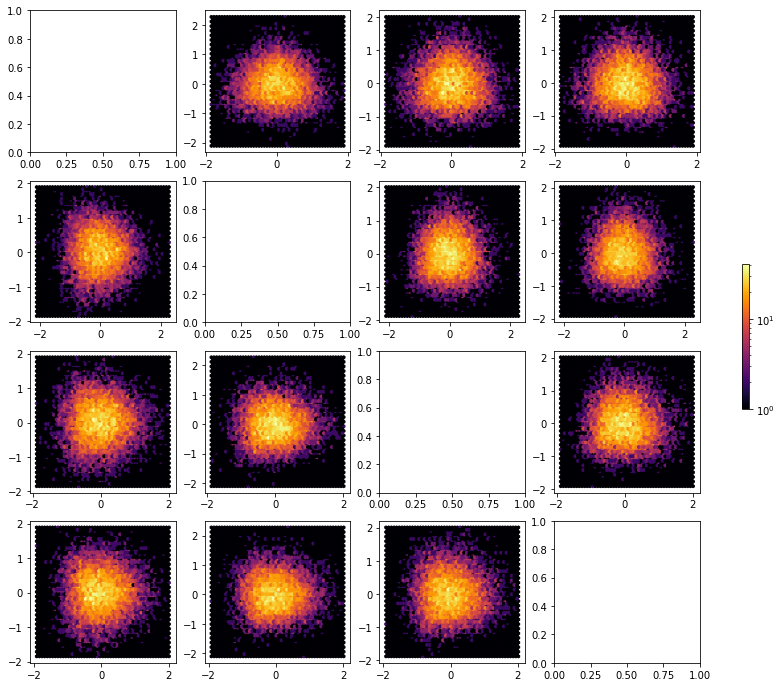

In [21]:
plotCompositionPairs(ilr_boxcox(data, .1))

# 3d composition plots

In [195]:
from mpl_toolkits import mplot3d
from IPython.display import clear_output

In [196]:
n = 1000
D = 4

data2 = makeDirichletComposition(n, D)
# data2 = makeComposition(n, D)
# data2 = clr_boxcox(data2, 0.25)
data2 = ilr_boxcox(data2, .1)

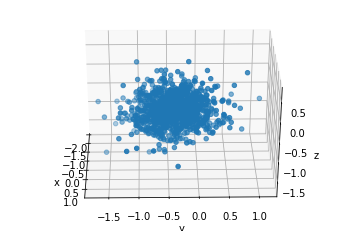

In [197]:
# ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
xdata = data2[:, 0]
ydata = data2[:, 1]
zdata = data2[:, 2]

# ax.scatter3D(xdata, ydata, zdata, alpha=0.2, color='b')
# ax.view_init(30, 60)

# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# plt.show()


# rotate the axes and update
for angle in range(0, 360):
    ax = plt.axes(projection='3d')
    ax.scatter3D(xdata, ydata, zdata)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    ax.view_init(30, angle)
    plt.savefig("gif_plots/plt%d.png" %angle)
#     plt.pause(.0000000001)
    clear_output(wait=False);

In [198]:
import imageio
images = []
for angle in range(0, 360):
    images.append(imageio.imread('gif_plots/plt%d.png' %angle))
imageio.mimsave('ilr_boxcox_dirichlet3d.gif', images)